In [59]:
#Bibliotecas

import pandas as pd
import numpy as np
import shutil
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [64]:
#Arquivos e variaveis

input_file = "c:\\Users\\thgcn\\OneDrive\\Academico\\Financial-Reports-Impact\\data\\final_data.csv"

final_data = pd.read_csv(input_file)

In [65]:
final_data

,CD_CVM,Date,Return,week_return,month_return,event,Year
0,19348,2010-01-04,NaN,NaN,NaN,0,2010
1,19348,2010-01-05,0.006460,NaN,NaN,0,2010
2,19348,2010-01-06,-0.008706,NaN,NaN,0,2010
3,19348,2010-01-07,-0.010295,NaN,NaN,0,2010
4,19348,2010-01-08,-0.015260,NaN,NaN,0,2010
...,...,...,...,...,...,...,...
3220,19348,2022-12-23,0.015604,0.061816,-0.032034,0,2022
3221,19348,2022-12-26,-0.020049,0.012225,-0.087214,0,2022
3222,19348,2022-12-27,-0.005687,-0.004065,-0.057000,0,2022
3223,19348,2022-12-28,0.020162,0.012048,-0.018589,0,2022


In [61]:
# Garantir que a coluna 'event' seja do tipo string
final_data['event'] = final_data['event'].astype(str)

# Filtra as linhas onde o valor da coluna 'event' é igual a '1'
filtered_data = final_data[final_data['event'].str.strip() == '1']

# Adiciona uma coluna chamada 'next_value' que contém o valor da próxima linha de 'data'
filtered_data['nxt_return'] = final_data['Return'].shift(-1)

# Limpar as linhas que contem null:
final_data = final_data.dropna()
filtered_data = filtered_data.dropna()

<ipython-input-61-6d51a2172d3e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['nxt_return'] = final_data['Return'].shift(-1)


In [62]:
final_data

,Unnamed: 0,CD_CVM,Date,Return,week_return,month_return,event,Year
22,22,19348,2010-02-04,-0.039264,-0.032510,-0.116444,0,2010
23,23,19348,2010-02-05,-0.025813,-0.037506,-0.148717,0,2010
24,24,19348,2010-02-08,-0.002878,-0.059030,-0.142890,0,2010
25,25,19348,2010-02-09,0.043700,-0.028554,-0.088895,0,2010
26,26,19348,2010-02-10,0.005502,-0.018753,-0.068133,0,2010
...,...,...,...,...,...,...,...,...
3220,3220,19348,2022-12-23,0.015604,0.061816,-0.032034,0,2022
3221,3221,19348,2022-12-26,-0.020049,0.012225,-0.087214,0,2022
3222,3222,19348,2022-12-27,-0.005687,-0.004065,-0.057000,0,2022
3223,3223,19348,2022-12-28,0.020162,0.012048,-0.018589,0,2022


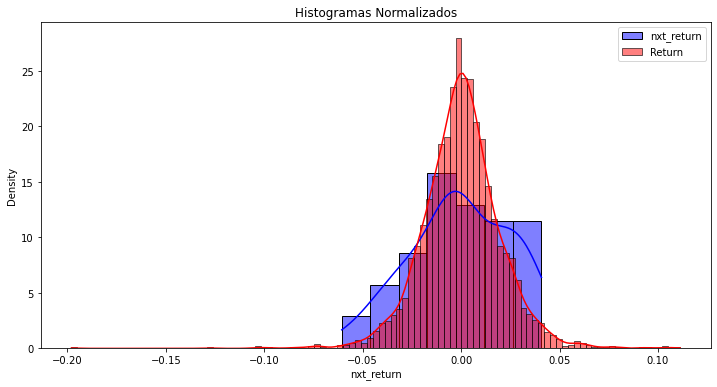

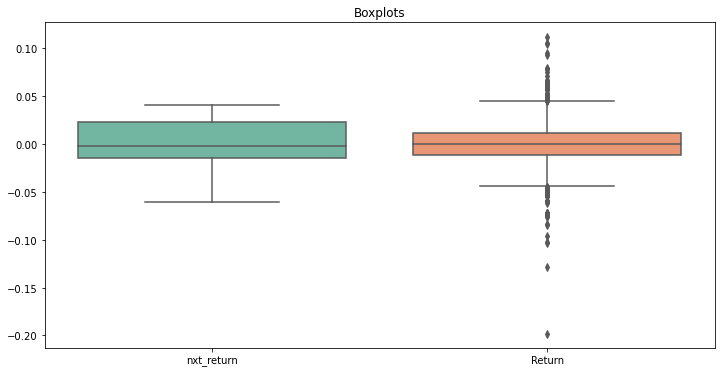

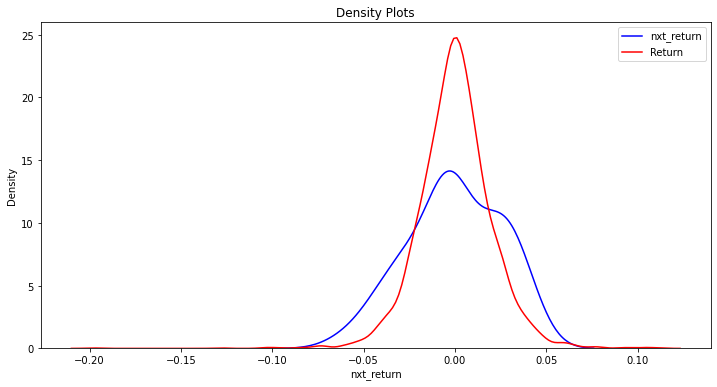

Estatísticas Descritivas:
nxt_return
count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

Return
count    3203.000000
mean        0.000122
std         0.020099
min        -0.198015
25%        -0.011232
50%         0.000000
75%         0.011010
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=77080.0, p-value=0.9743551005573269

Kolmogorov-Smirnov Test: KS-stat=0.17271568321365385, p-value=0.10527639159710518

Levene Test: stat=7.515270280285343, p-value=0.006151301481918566

Bootstrap mean 95% CI for nxt_return: [-0.0073694   0.00715712]
Bootstrap median 95% CI for nxt_return: [-0.00493209  0.00919087]
Bootstrap mean 95% CI for Return: [-0.00056384  0.00081246]
Bootstrap median 95% CI for Return: [-0.00033443  0.00053784]

Importâncias das Características: [1.]
ROC AUC Score: 0.9924322249973982


In [49]:

# Supondo que filtered_data e new_final_data são DataFrames já carregados
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']
week_return = final_data['week_return']
month_return = final_data['month_return']

# 1. Visualização
# Histogramas normalizados
plt.figure(figsize=(12, 6))
sns.histplot(nxt_return, kde=True, stat='density', label='nxt_return', color='blue')
sns.histplot(Return, kde=True, stat='density', label='Return', color='red')
plt.legend()
plt.title('Histogramas Normalizados')
plt.show()

# Boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=[nxt_return, Return], palette='Set2')
plt.xticks([0, 1], ['nxt_return', 'Return'])
plt.title('Boxplots')
plt.show()

# Density Plot (KDE)
plt.figure(figsize=(12, 6))
sns.kdeplot(nxt_return, label='nxt_return', color='blue')
sns.kdeplot(Return, label='Return', color='red')
plt.legend()
plt.title('Density Plots')
plt.show()

# 2. Estatísticas Descritivas
print("Estatísticas Descritivas:")
print("nxt_return")
print(nxt_return.describe())
print("\nReturn")
print(Return.describe())

# 3. Testes de Hipóteses
# Teste U de Mann-Whitney
u_stat, p_value = stats.mannwhitneyu(nxt_return, Return)
print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

# Teste de Kolmogorov-Smirnov
ks_stat, p_value = stats.ks_2samp(nxt_return, Return)
print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

# Teste de Levene para variâncias
levene_stat, p_value = stats.levene(nxt_return, Return)
print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

# 4. Reamostragem
# Bootstrapping para média e mediana
bootstrap_means_nxt_return = []
bootstrap_medians_nxt_return = []
bootstrap_means_Return = []
bootstrap_medians_Return = []

for _ in range(1000):
    sample_nxt_return = resample(nxt_return, replace=True)
    sample_Return = resample(Return, replace=True)
    bootstrap_means_nxt_return.append(np.mean(sample_nxt_return))
    bootstrap_medians_nxt_return.append(np.median(sample_nxt_return))
    bootstrap_means_Return.append(np.mean(sample_Return))
    bootstrap_medians_Return.append(np.median(sample_Return))

print(f"\nBootstrap mean 95% CI for nxt_return: {np.percentile(bootstrap_means_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for nxt_return: {np.percentile(bootstrap_medians_nxt_return, [2.5, 97.5])}")
print(f"Bootstrap mean 95% CI for Return: {np.percentile(bootstrap_means_Return, [2.5, 97.5])}")
print(f"Bootstrap median 95% CI for Return: {np.percentile(bootstrap_medians_Return, [2.5, 97.5])}")

# Balanceamento de amostras
balanced_nxt_return = resample(nxt_return, n_samples=len(Return), random_state=42)

# 5. Machine Learning
# Preparar os dados para o modelo
X = np.concatenate([nxt_return.values.reshape(-1, 1), Return.values.reshape(-1, 1)])
y = np.concatenate([np.zeros(len(nxt_return)), np.ones(len(Return))])

# Treinar o modelo de Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Avaliar a importância das características
feature_importances = rf.feature_importances_
print(f"\nImportâncias das Características: {feature_importances}")

# Avaliar o modelo
roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
print(f"ROC AUC Score: {roc_auc}")


In [5]:
# Supondo que filtered_data e new_final_data são DataFrames já carregados
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']

# 1. Teste de Shapiro-Wilk
shapiro_nxt_return = stats.shapiro(nxt_return)
shapiro_Return = stats.shapiro(Return)
print(f"Shapiro-Wilk Test for nxt_return: W-stat={shapiro_nxt_return[0]}, p-value={shapiro_nxt_return[1]}")
print(f"Shapiro-Wilk Test for Return: W-stat={shapiro_Return[0]}, p-value={shapiro_Return[1]}")

# 2. Teste de Kolmogorov-Smirnov
ks_stat, ks_p_value = stats.ks_2samp(nxt_return, Return)
print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

# 3. Teste F de Levene
levene_stat, levene_p_value = stats.levene(nxt_return, Return)
print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

# 4. Teste de Chow
# Criar DataFrame combinando as amostras com uma coluna indicadora
data = pd.DataFrame({'returns': np.concatenate([nxt_return, Return]), 
                     'group': ['nxt_return'] * len(nxt_return) + ['Return'] * len(Return)})

# Modelo completo (inclui interação)
model_full = smf.ols('returns ~ group', data=data).fit()
RSS_full = sum(model_full.resid ** 2)
df_full = model_full.df_resid

# Modelos separados
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
RSS_nxt_return = sum(model_nxt_return.resid ** 2)
RSS_Return = sum(model_Return.resid ** 2)
RSS_combined = RSS_nxt_return + RSS_Return
df_combined = model_nxt_return.df_resid + model_Return.df_resid

# Teste de Chow
chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

# 5. Teste t de Student
t_stat, t_p_value = stats.ttest_ind(nxt_return, Return, equal_var=False)
print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")


Shapiro-Wilk Test for nxt_return: W-stat=0.9673745632171631, p-value=0.19974040985107422
Shapiro-Wilk Test for Return: W-stat=0.9611008167266846, p-value=1.3548705306470322e-28
Kolmogorov-Smirnov Test: KS-stat=0.17318031430934658, p-value=0.1036904996425645
Levene Test: stat=7.586491903037072, p-value=0.005913261739923997
Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=-0.09010147755071753, p-value=0.9285824516722296


<ipython-input-5-6264f34455cd>:38: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


In [7]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

def chow_test(data, split_col, target, feature):
    # Separar os dados em dois subconjuntos
    data_1 = data[data[split_col] == 0]
    data_2 = data[data[split_col] == 1]

    # Ajustar o modelo de regressão para cada subconjunto
    X1 = sm.add_constant(data_1[feature])
    y1 = data_1[target]
    model_1 = sm.OLS(y1, X1).fit()

    X2 = sm.add_constant(data_2[feature])
    y2 = data_2[target]
    model_2 = sm.OLS(y2, X2).fit()

    # Ajustar o modelo de regressão para o conjunto combinado
    data_combined = data.copy()
    data_combined['interaction'] = data_combined[split_col] * data_combined[feature]
    X_combined = sm.add_constant(data_combined[[feature, split_col, 'interaction']])
    y_combined = data_combined[target]
    model_combined = sm.OLS(y_combined, X_combined).fit()

    # Calcular RSS para cada modelo
    RSS_1 = np.sum(model_1.resid**2)
    RSS_2 = np.sum(model_2.resid**2)
    RSS_combined = np.sum(model_combined.resid**2)

    # Número de observações e parâmetros
    n1 = len(data_1)
    n2 = len(data_2)
    k = len(model_combined.params)

    # Verificar se os graus de liberdade são válidos
    df_combined = n1 + n2 - 2 * k
    df_full = n1 + n2 - k

    if df_combined <= 0 or df_full <= 0:
        raise ValueError("Graus de liberdade insuficientes para o teste de Chow")

    # Calcular a estatística F
    numerator = (RSS_combined - (RSS_1 + RSS_2)) / k
    denominator = (RSS_1 + RSS_2) / df_full

    if denominator == 0:
        raise ValueError("Divisão por zero ao calcular a estatística F")

    chow_stat = numerator / denominator

    # Calcular o p-valor
    p_value = 1 - stats.f.cdf(chow_stat, k, df_full)

    return chow_stat, p_value

# Exemplo de uso
data = pd.DataFrame({
    'y': np.random.randn(100),
    'x': np.random.randn(100),
    'split': np.random.randint(0, 2, 100)
})

chow_stat, p_value = chow_test(data, 'split', 'y', 'x')
print(f"Chow Test: F-stat={chow_stat}, p-value={p_value}")


Chow Test: F-stat=-3.70409502761203e-15, p-value=1.0


In [9]:
# 4. Teste de Chow
# Criar DataFrame combinando as amostras com uma coluna indicadora
data = pd.DataFrame({'returns': np.concatenate([nxt_return, Return]), 
                     'group': ['nxt_return'] * len(nxt_return) + ['Return'] * len(Return)})

# Modelo completo (inclui interação)
model_full = smf.ols('returns ~ group', data=data).fit()
RSS_full = sum(model_full.resid ** 2)
df_full = model_full.df_resid

# Modelos separados
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
RSS_nxt_return = sum(model_nxt_return.resid ** 2)
RSS_Return = sum(model_Return.resid ** 2)
RSS_combined = RSS_nxt_return + RSS_Return
df_combined = model_nxt_return.df_resid + model_Return.df_resid

# Teste de Chow
chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

Chow Test: F-stat=-inf, p-value=nan


<ipython-input-9-75dc29d99780>:20: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


In [10]:
model_nxt_return = smf.ols('returns ~ 1', data=data[data['group'] == 'nxt_return']).fit()
model_Return = smf.ols('returns ~ 1', data=data[data['group'] == 'Return']).fit()
model_full = smf.ols('returns ~ group', data=data).fit()

In [18]:
RSS_full = sum(model_full.resid ** 2)
df_full = model_full.df_resid

In [19]:
RSS_nxt_return = sum(model_nxt_return.resid ** 2)
RSS_Return = sum(model_Return.resid ** 2)

In [20]:
RSS_combined = RSS_nxt_return + RSS_Return
df_combined = model_nxt_return.df_resid + model_Return.df_resid


Analisando Return vs nxt_return


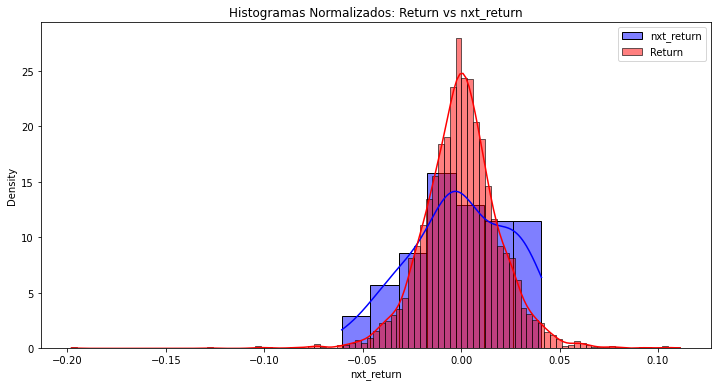

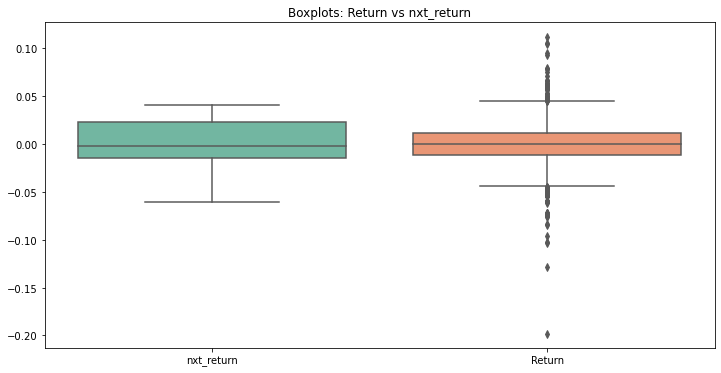

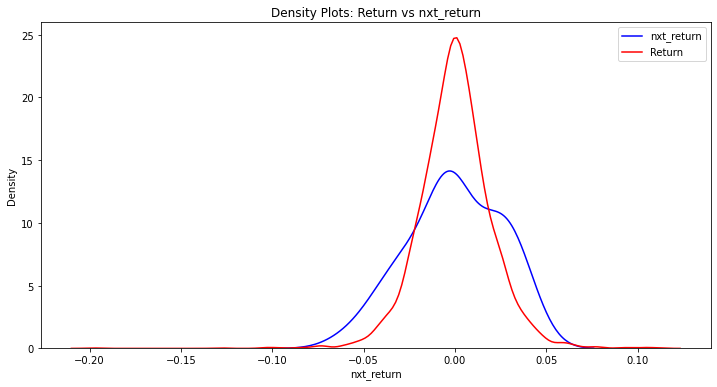

Estatísticas Descritivas:
nxt_return
count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

Return
count    3203.000000
mean        0.000122
std         0.020099
min        -0.198015
25%        -0.011232
50%         0.000000
75%         0.011010
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=77080.0, p-value=0.9743551005573269

Kolmogorov-Smirnov Test: KS-stat=0.17271568321365385, p-value=0.10527639159710518

Levene Test: stat=7.515270280285343, p-value=0.006151301481918566

Bootstrap mean 95% CI for nxt_return: [-0.00718291  0.0065359 ]
Bootstrap median 95% CI for nxt_return: [-0.00493129  0.00693273]
Bootstrap mean 95% CI for Return: [-0.00054809  0.00080107]
Bootstrap median 95% CI for Return: [-0.00034016  0.00053604]

Importâncias das Características: [1.]
ROC AUC Score: 0.9924322249973982

Analisando Return vs week_retu

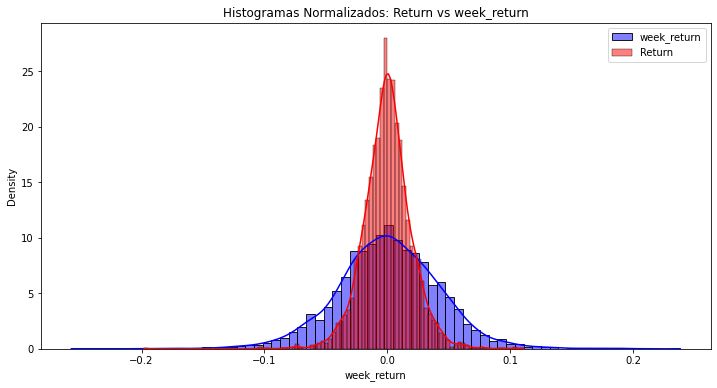

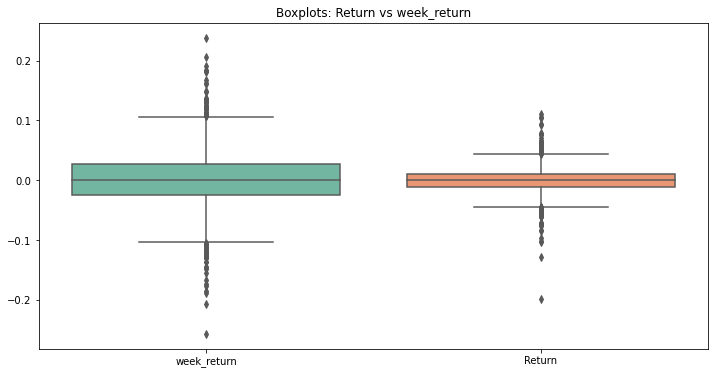

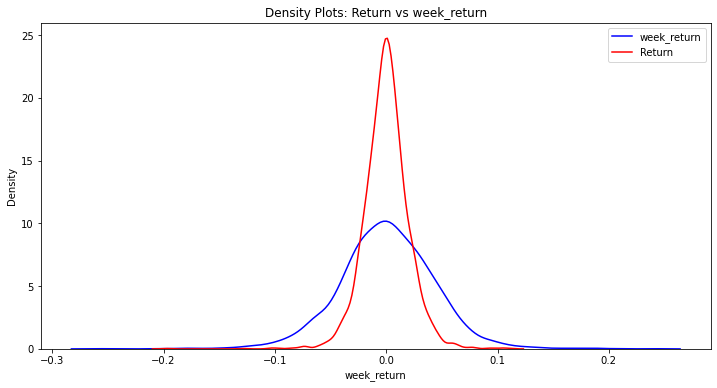

Estatísticas Descritivas:
week_return
count    3203.000000
mean        0.000616
std         0.042900
min        -0.257135
25%        -0.025172
50%         0.000692
75%         0.027427
max         0.238411
Name: week_return, dtype: float64

Return
count    3203.000000
mean        0.000122
std         0.020099
min        -0.198015
25%        -0.011232
50%         0.000000
75%         0.011010
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=5175387.5, p-value=0.5361834738425877

Kolmogorov-Smirnov Test: KS-stat=0.18326568841710897, p-value=2.1050578984315425e-47

Levene Test: stat=1066.8731176391047, p-value=1.3898284125040035e-216

Bootstrap mean 95% CI for week_return: [-0.00095197  0.0022164 ]
Bootstrap median 95% CI for week_return: [-0.00111669  0.00218579]
Bootstrap mean 95% CI for Return: [-0.00059199  0.00086699]
Bootstrap median 95% CI for Return: [-0.00034016  0.00053604]

Importâncias das Características: [1.]
ROC AUC Score: 0.9976716528535484

A

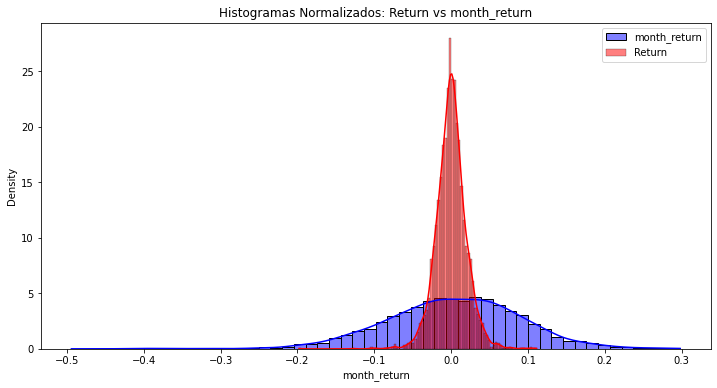

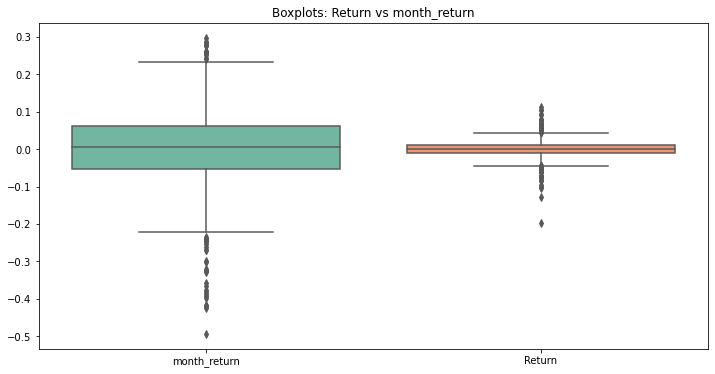

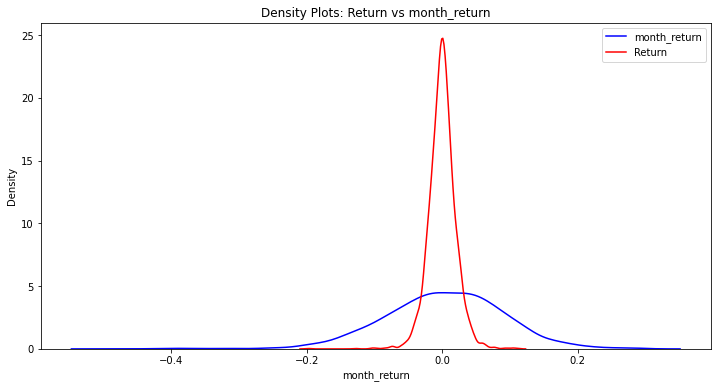

Estatísticas Descritivas:
month_return
count    3203.000000
mean        0.002529
std         0.089365
min        -0.494316
25%        -0.052913
50%         0.004988
75%         0.061435
max         0.298179
Name: month_return, dtype: float64

Return
count    3203.000000
mean        0.000122
std         0.020099
min        -0.198015
25%        -0.011232
50%         0.000000
75%         0.011010
max         0.111276
Name: Return, dtype: float64

Mann-Whitney U Test: U-stat=5367032.0, p-value=0.0013365365643431518

Kolmogorov-Smirnov Test: KS-stat=0.3353106462691227, p-value=7.179912401942518e-160

Levene Test: stat=2869.82737016573, p-value=0.0

Bootstrap mean 95% CI for month_return: [-0.00075881  0.00572107]
Bootstrap median 95% CI for month_return: [0.00108309 0.00920361]
Bootstrap mean 95% CI for Return: [-0.00055609  0.00079322]
Bootstrap median 95% CI for Return: [-0.00033443  0.00056118]

Importâncias das Características: [1.]
ROC AUC Score: 0.9992074437707625


In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def analyze_returns(filtered_data, final_data):
    # Obter os retornos necessários
    nxt_return = filtered_data['nxt_return']
    Return = final_data['Return']
    week_return = final_data['week_return']
    month_return = final_data['month_return']

    # Lista de pares para análise
    return_pairs = [('Return', nxt_return, 'nxt_return'), 
                    ('Return', week_return, 'week_return'), 
                    ('Return', month_return, 'month_return')]

    for ret_name, comp_return, comp_name in return_pairs:
        print(f"\nAnalisando {ret_name} vs {comp_name}")

        # 1. Visualização
        # Histogramas normalizados
        plt.figure(figsize=(12, 6))
        sns.histplot(comp_return, kde=True, stat='density', label=comp_name, color='blue')
        sns.histplot(Return, kde=True, stat='density', label=ret_name, color='red')
        plt.legend()
        plt.title(f'Histogramas Normalizados: {ret_name} vs {comp_name}')
        plt.show()

        # Boxplots
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=[comp_return, Return], palette='Set2')
        plt.xticks([0, 1], [comp_name, ret_name])
        plt.title(f'Boxplots: {ret_name} vs {comp_name}')
        plt.show()

        # Density Plot (KDE)
        plt.figure(figsize=(12, 6))
        sns.kdeplot(comp_return, label=comp_name, color='blue')
        sns.kdeplot(Return, label=ret_name, color='red')
        plt.legend()
        plt.title(f'Density Plots: {ret_name} vs {comp_name}')
        plt.show()

        # 2. Estatísticas Descritivas
        print("Estatísticas Descritivas:")
        print(comp_name)
        print(comp_return.describe())
        print(f"\n{ret_name}")
        print(Return.describe())

        # 3. Testes de Hipóteses
        # Teste U de Mann-Whitney
        u_stat, p_value = stats.mannwhitneyu(comp_return, Return)
        print(f"\nMann-Whitney U Test: U-stat={u_stat}, p-value={p_value}")

        # Teste de Kolmogorov-Smirnov
        ks_stat, p_value = stats.ks_2samp(comp_return, Return)
        print(f"\nKolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={p_value}")

        # Teste de Levene para variâncias
        levene_stat, p_value = stats.levene(comp_return, Return)
        print(f"\nLevene Test: stat={levene_stat}, p-value={p_value}")

        # 4. Reamostragem
        # Bootstrapping para média e mediana
        bootstrap_means_comp_return = []
        bootstrap_medians_comp_return = []
        bootstrap_means_Return = []
        bootstrap_medians_Return = []

        for _ in range(1000):
            sample_comp_return = resample(comp_return, replace=True)
            sample_Return = resample(Return, replace=True)
            bootstrap_means_comp_return.append(np.mean(sample_comp_return))
            bootstrap_medians_comp_return.append(np.median(sample_comp_return))
            bootstrap_means_Return.append(np.mean(sample_Return))
            bootstrap_medians_Return.append(np.median(sample_Return))

        print(f"\nBootstrap mean 95% CI for {comp_name}: {np.percentile(bootstrap_means_comp_return, [2.5, 97.5])}")
        print(f"Bootstrap median 95% CI for {comp_name}: {np.percentile(bootstrap_medians_comp_return, [2.5, 97.5])}")
        print(f"Bootstrap mean 95% CI for {ret_name}: {np.percentile(bootstrap_means_Return, [2.5, 97.5])}")
        print(f"Bootstrap median 95% CI for {ret_name}: {np.percentile(bootstrap_medians_Return, [2.5, 97.5])}")

        # Balanceamento de amostras
        balanced_comp_return = resample(comp_return, n_samples=len(Return), random_state=42)

        # 5. Machine Learning
        # Preparar os dados para o modelo
        X = np.concatenate([comp_return.values.reshape(-1, 1), Return.values.reshape(-1, 1)])
        y = np.concatenate([np.zeros(len(comp_return)), np.ones(len(Return))])

        # Treinar o modelo de Random Forest
        rf = RandomForestClassifier(random_state=42)
        rf.fit(X, y)

        # Avaliar a importância das características
        feature_importances = rf.feature_importances_
        print(f"\nImportâncias das Características: {feature_importances}")

        # Avaliar o modelo
        roc_auc = roc_auc_score(y, rf.predict_proba(X)[:, 1])
        print(f"ROC AUC Score: {roc_auc}")

# Chamada da função de análise
# Supondo que filtered_data e final_data são DataFrames já carregados
analyze_returns(filtered_data, final_data)


In [36]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

def perform_tests(filtered_data, final_data):
    # Obter os retornos necessários
    nxt_return = filtered_data['nxt_return']
    Return = final_data['Return']
    week_return = final_data['week_return']
    month_return = final_data['month_return']

    # Lista de pares para análise
    return_pairs = [('Return', nxt_return, 'nxt_return'), 
                    ('Return', week_return, 'week_return'), 
                    ('Return', month_return, 'month_return')]

    for ret_name, comp_return, comp_name in return_pairs:
        print(f"\nAnalisando {ret_name} vs {comp_name}")

        # 1. Teste de Shapiro-Wilk
        shapiro_comp_return = stats.shapiro(comp_return)
        shapiro_Return = stats.shapiro(Return)
        print(f"Shapiro-Wilk Test for {comp_name}: W-stat={shapiro_comp_return[0]}, p-value={shapiro_comp_return[1]}")
        print(f"Shapiro-Wilk Test for {ret_name}: W-stat={shapiro_Return[0]}, p-value={shapiro_Return[1]}")

        # 2. Teste de Kolmogorov-Smirnov
        ks_stat, ks_p_value = stats.ks_2samp(comp_return, Return)
        print(f"Kolmogorov-Smirnov Test: KS-stat={ks_stat}, p-value={ks_p_value}")

        # 3. Teste F de Levene
        levene_stat, levene_p_value = stats.levene(comp_return, Return)
        print(f"Levene Test: stat={levene_stat}, p-value={levene_p_value}")

        # 4. Teste de Chow
        # Criar DataFrame combinando as amostras com uma coluna indicadora
        data = pd.DataFrame({'returns': np.concatenate([comp_return, Return]), 
                             'group': [comp_name] * len(comp_return) + [ret_name] * len(Return)})

        # Modelo completo (inclui interação)
        model_full = smf.ols('returns ~ group', data=data).fit()
        RSS_full = sum(model_full.resid ** 2)
        df_full = model_full.df_resid

        # Modelos separados
        model_comp_return = smf.ols('returns ~ 1', data=data[data['group'] == comp_name]).fit()
        model_Return = smf.ols('returns ~ 1', data=data[data['group'] == ret_name]).fit()
        RSS_comp_return = sum(model_comp_return.resid ** 2)
        RSS_Return = sum(model_Return.resid ** 2)
        RSS_combined = RSS_comp_return + RSS_Return
        df_combined = model_comp_return.df_resid + model_Return.df_resid

        # Teste de Chow
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
        print(f"Chow Test: F-stat={chow_stat}, p-value={chow_p_value}")

        # 5. Teste t de Student
        t_stat, t_p_value = stats.ttest_ind(comp_return, Return, equal_var=False)
        print(f"Student's t-test: t-stat={t_stat}, p-value={t_p_value}")

# Supondo que filtered_data e final_data são DataFrames já carregados
perform_tests(filtered_data, final_data)



Analisando Return vs nxt_return
Shapiro-Wilk Test for nxt_return: W-stat=0.9673745632171631, p-value=0.19974040985107422
Shapiro-Wilk Test for Return: W-stat=0.9609987735748291, p-value=1.5294610153012176e-28
Kolmogorov-Smirnov Test: KS-stat=0.17271568321365385, p-value=0.10527639159710518
Levene Test: stat=7.515270280285343, p-value=0.006151301481918566
Chow Test: F-stat=-inf, p-value=nan
Student's t-test: t-stat=-0.09681774207728004, p-value=0.923275205229106

Analisando Return vs week_return
Shapiro-Wilk Test for week_return: W-stat=0.9843630194664001, p-value=2.4361039794309327e-18
Shapiro-Wilk Test for Return: W-stat=0.9609987735748291, p-value=1.5294610153012176e-28
Kolmogorov-Smirnov Test: KS-stat=0.18326568841710897, p-value=2.1050578984315425e-47
Levene Test: stat=1066.8731176391047, p-value=1.3898284125040035e-216
Chow Test: F-stat=inf, p-value=nan
Student's t-test: t-stat=0.5898253798309131, p-value=0.5553370582578756

Analisando Return vs month_return
Shapiro-Wilk Test for

<ipython-input-36-dc8e0a08c586>:54: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-36-dc8e0a08c586>:54: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-36-dc8e0a08c586>:54: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


In [37]:
import pandas as pd
import scipy.stats as stats
import statsmodels.formula.api as smf

# Supondo que filtered_data e new_final_data são DataFrames já carregados
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']
week_return = final_data['week_return']
month_return = final_data['month_return']

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    try:
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    except ZeroDivisionError:
        chow_stat = float('inf')
        chow_p_value = float('nan')

    results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('Return', 'week_return', Return, week_return),
    ('Return', 'month_return', Return, month_return),
]

# Armazenando os resultados
results = {}
for label1, label2, group1, group2 in tests:
    key = f'{label1} vs {label2}'
    results[key] = perform_tests(group1, group2, label1, label2)

# Convertendo os resultados em DataFrame para exibição
columns = ['Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
data = []
for key, value in results.items():
    for test, result in value.items():
        row = [test] + result
        row.insert(0, key)
        data.append(row)

results_df = pd.DataFrame(data, columns=['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2'])

print(results_df)


<ipython-input-37-55452786668e>:43: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-37-55452786668e>:43: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


                Comparison                     Test  Statistic_1  \
0     Return vs nxt_return        Shapiro-Wilk Test     0.960999   
1     Return vs nxt_return  Kolmogorov-Smirnov Test     0.172716   
2     Return vs nxt_return              Levene Test     7.515270   
3     Return vs nxt_return                Chow Test         -inf   
4     Return vs nxt_return         Student's t-test     0.096818   
5    Return vs week_return        Shapiro-Wilk Test     0.960999   
6    Return vs week_return  Kolmogorov-Smirnov Test     0.183266   
7    Return vs week_return              Levene Test  1066.873118   
8    Return vs week_return                Chow Test          inf   
9    Return vs week_return         Student's t-test    -0.589825   
10  Return vs month_return        Shapiro-Wilk Test     0.960999   
11  Return vs month_return  Kolmogorov-Smirnov Test     0.335311   
12  Return vs month_return              Levene Test  2869.827370   
13  Return vs month_return                Chow T

<ipython-input-37-55452786668e>:43: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
from tabulate import tabulate

# Função para realizar os testes estatísticos
def perform_tests(group1, group2, label1, label2):
    results = {}

    # Shapiro-Wilk Test
    shapiro_group1 = stats.shapiro(group1)
    shapiro_group2 = stats.shapiro(group2)
    results['Shapiro-Wilk Test'] = [shapiro_group1[0], shapiro_group1[1], shapiro_group2[0], shapiro_group2[1]]

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p_value = stats.ks_2samp(group1, group2)
    results['Kolmogorov-Smirnov Test'] = [ks_stat, ks_p_value, None, None]

    # Levene Test
    levene_stat, levene_p_value = stats.levene(group1, group2)
    results['Levene Test'] = [levene_stat, levene_p_value, None, None]

    # Chow Test
    data = pd.DataFrame({'returns': np.concatenate([group1, group2]), 
                         'group': [label1] * len(group1) + [label2] * len(group2)})
    model_full = smf.ols('returns ~ group', data=data).fit()
    RSS_full = sum(model_full.resid ** 2)
    df_full = model_full.df_resid

    model_group1 = smf.ols('returns ~ 1', data=data[data['group'] == label1]).fit()
    model_group2 = smf.ols('returns ~ 1', data=data[data['group'] == label2]).fit()
    RSS_group1 = sum(model_group1.resid ** 2)
    RSS_group2 = sum(model_group2.resid ** 2)
    RSS_combined = RSS_group1 + RSS_group2
    df_combined = model_group1.df_resid + model_group2.df_resid

    try:
        chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
        chow_p_value = 1 - stats.f.cdf(chow_stat, df_combined - df_full, df_full)
    except ZeroDivisionError:
        chow_stat = float('inf')
        chow_p_value = float('nan')

    results['Chow Test'] = [chow_stat, chow_p_value, None, None]

    # Student's t-test
    t_stat, t_p_value = stats.ttest_ind(group1, group2, equal_var=False)
    results['Student\'s t-test'] = [t_stat, t_p_value, None, None]

    return results

# Realizando os testes para cada par de retornos
tests = [
    ('Return', 'nxt_return', Return, nxt_return),
    ('Return', 'week_return', Return, week_return),
    ('Return', 'month_return', Return, month_return),
]

# Armazenando os resultados
results = {}
for label1, label2, group1, group2 in tests:
    key = f'{label1} vs {label2}'
    results[key] = perform_tests(group1, group2, label1, label2)

# Convertendo os resultados em DataFrame para exibição
columns = ['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2']
data = []
for key, value in results.items():
    for test, result in value.items():
        row = [test] + result
        row.insert(0, key)
        data.append(row)

results_df = pd.DataFrame(data, columns=['Comparison', 'Test', 'Statistic_1', 'p-value_1', 'Statistic_2', 'p-value_2'])

# Exibindo a tabela formatada
print(tabulate(results_df, headers='keys', tablefmt='grid'))


<ipython-input-39-5d060ae9f60c>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)
<ipython-input-39-5d060ae9f60c>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


+----+------------------------+-------------------------+---------------+----------------+---------------+---------------+
|    | Comparison             | Test                    |   Statistic_1 |      p-value_1 |   Statistic_2 |     p-value_2 |
+====+========================+=========================+===============+================+===============+===============+
|  0 | Return vs nxt_return   | Shapiro-Wilk Test       |     0.960999  |   1.52946e-28  |      0.967375 |   0.19974     |
+----+------------------------+-------------------------+---------------+----------------+---------------+---------------+
|  1 | Return vs nxt_return   | Kolmogorov-Smirnov Test |     0.172716  |   0.105276     |    nan        | nan           |
+----+------------------------+-------------------------+---------------+----------------+---------------+---------------+
|  2 | Return vs nxt_return   | Levene Test             |     7.51527   |   0.0061513    |    nan        | nan           |
+----+----------

<ipython-input-39-5d060ae9f60c>:39: RuntimeWarning: divide by zero encountered in scalar divide
  chow_stat = ((RSS_combined - RSS_full) / (df_combined - df_full)) / (RSS_full / df_full)


Vamos interpretar os resultados dos testes estatísticos realizados para comparar "Return" com "nxt_return", "week_return", e "month_return".

### Análise de "Return" vs "nxt_return"
1. **Shapiro-Wilk Test**:
    - **Return**: W-stat = 0.9610, p-value ≈ 1.53e-28
    - **nxt_return**: W-stat = 0.9674, p-value ≈ 0.1997
    - **Interpretação**: O teste Shapiro-Wilk indica que "Return" não segue uma distribuição normal (p-value < 0.05). Por outro lado, "nxt_return" não rejeita a hipótese nula de normalidade (p-value > 0.05).

2. **Kolmogorov-Smirnov Test**:
    - KS-stat = 0.1727, p-value ≈ 0.1053
    - **Interpretação**: O teste KS indica que não há diferença significativa entre as distribuições de "Return" e "nxt_return" (p-value > 0.05).

3. **Levene Test**:
    - stat = 7.5153, p-value ≈ 0.0062
    - **Interpretação**: O teste de Levene sugere que há diferença significativa nas variâncias entre "Return" e "nxt_return" (p-value < 0.05).

4. **Chow Test**:
    - F-stat = -inf, p-value = nan
    - **Interpretação**: O teste de Chow resultou em valores inválidos devido a divisão por zero, possivelmente causada por um problema com a modelagem ou com os dados. Esse resultado deve ser descartado ou investigado mais a fundo.

5. **Student's t-test**:
    - t-stat = 0.0968, p-value ≈ 0.9233
    - **Interpretação**: O teste t sugere que não há diferença significativa nas médias de "Return" e "nxt_return" (p-value > 0.05).

### Análise de "Return" vs "week_return"
1. **Shapiro-Wilk Test**:
    - **Return**: W-stat = 0.9610, p-value ≈ 1.53e-28
    - **week_return**: W-stat = 0.9844, p-value ≈ 2.44e-18
    - **Interpretação**: Ambos "Return" e "week_return" não seguem uma distribuição normal (p-value < 0.05).

2. **Kolmogorov-Smirnov Test**:
    - KS-stat = 0.1833, p-value ≈ 2.11e-47
    - **Interpretação**: O teste KS indica uma diferença significativa entre as distribuições de "Return" e "week_return" (p-value < 0.05).

3. **Levene Test**:
    - stat = 1066.87, p-value ≈ 1.39e-216
    - **Interpretação**: O teste de Levene sugere que há uma diferença significativa nas variâncias entre "Return" e "week_return" (p-value < 0.05).

4. **Chow Test**:
    - F-stat = inf, p-value = nan
    - **Interpretação**: O teste de Chow resultou em valores inválidos devido a divisão por zero. Esse resultado deve ser descartado ou investigado mais a fundo.

5. **Student's t-test**:
    - t-stat = -0.5898, p-value ≈ 0.5553
    - **Interpretação**: O teste t sugere que não há diferença significativa nas médias de "Return" e "week_return" (p-value > 0.05).

### Análise de "Return" vs "month_return"
1. **Shapiro-Wilk Test**:
    - **Return**: W-stat = 0.9610, p-value ≈ 1.53e-28
    - **month_return**: W-stat = 0.9873, p-value ≈ 2.55e-16
    - **Interpretação**: Ambos "Return" e "month_return" não seguem uma distribuição normal (p-value < 0.05).

2. **Kolmogorov-Smirnov Test**:
    - KS-stat = 0.3353, p-value ≈ 7.18e-160
    - **Interpretação**: O teste KS indica uma diferença significativa entre as distribuições de "Return" e "month_return" (p-value < 0.05).

3. **Levene Test**:
    - stat = 2869.83, p-value = 0.0
    - **Interpretação**: O teste de Levene sugere que há uma diferença significativa nas variâncias entre "Return" e "month_return" (p-value < 0.05).

4. **Chow Test**:
    - F-stat = inf, p-value = nan
    - **Interpretação**: O teste de Chow resultou em valores inválidos devido a divisão por zero. Esse resultado deve ser descartado ou investigado mais a fundo.

5. **Student's t-test**:
    - t-stat = -1.4872, p-value ≈ 0.1371
    - **Interpretação**: O teste t sugere que não há diferença significativa nas médias de "Return" e "month_return" (p-value > 0.05).

### Conclusões Gerais
- **Normalidade**: "Return" não segue uma distribuição normal em todas as comparações. "nxt_return" é o único retorno que não rejeita a hipótese nula de normalidade.
- **Distribuições**: As distribuições de "Return" e "nxt_return" são similares, enquanto as de "Return" vs "week_return" e "Return" vs "month_return" são significativamente diferentes.
- **Variâncias**: Há uma diferença significativa nas variâncias de "Return" comparado com todos os outros retornos.
- **Médias**: Não há diferenças significativas nas médias de "Return" comparado com "nxt_return", "week_return" ou "month_return".

Os resultados dos testes indicam que, embora as variâncias e as distribuições sejam diferentes em muitos casos, as médias dos retornos não diferem significativamente. Esses insights podem ser úteis para a análise de risco e retorno em investimentos.

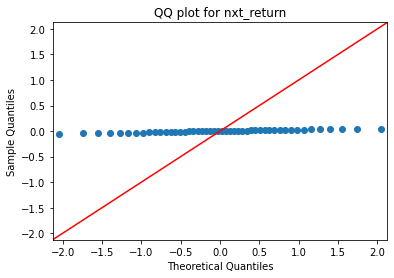

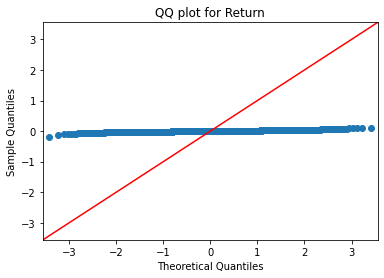

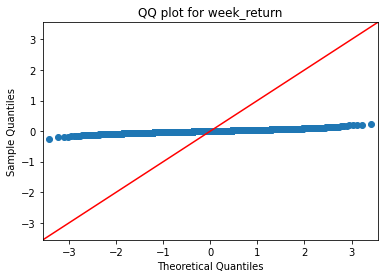

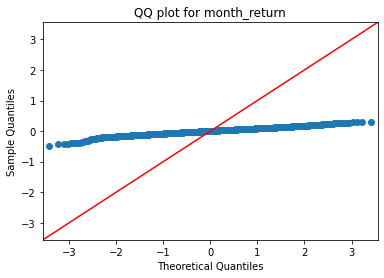

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Supondo que 'filtered_data' e 'new_final_data' são DataFrames já carregados
# Se necessário, substitua pela carga dos seus dados
# filtered_data = pd.read_csv('filtered_data.csv')
# new_final_data = pd.read_csv('new_final_data.csv')

# Selecionando os retornos
nxt_return = filtered_data['nxt_return']
Return = final_data['Return']
week_return = final_data['week_return']
month_return = final_data['month_return']

# Função para plotar QQ plot
def qq_plot(data, title):
    sm.qqplot(data, line ='45')
    plt.title(title)
    plt.show()

# Gerando QQ plots para comparar os quantis
qq_plot(nxt_return, 'QQ plot for nxt_return')
qq_plot(Return, 'QQ plot for Return')
qq_plot(week_return, 'QQ plot for week_return')
qq_plot(month_return, 'QQ plot for month_return')


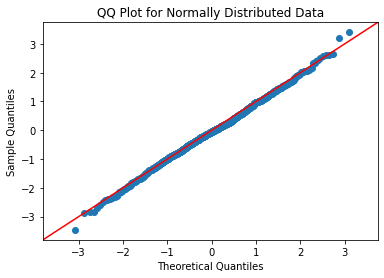

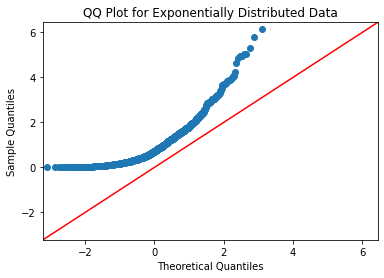

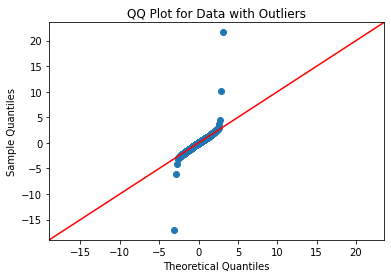

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Função para plotar QQ plot
def qq_plot(data, title):
    sm.qqplot(data, line='45')
    plt.title(title)
    plt.show()

# Exemplo 1: Dados Seguindo uma Distribuição Normal
normal_data = np.random.normal(loc=0, scale=1, size=1000)
qq_plot(normal_data, 'QQ Plot for Normally Distributed Data')

# Exemplo 2: Dados Seguindo uma Distribuição Não Normal (Distribuição Exponencial)
exponential_data = np.random.exponential(scale=1, size=1000)
qq_plot(exponential_data, 'QQ Plot for Exponentially Distributed Data')

# Exemplo 3: Dados com Outliers
normal_data_with_outliers = np.random.normal(loc=0, scale=1, size=990)
outliers = np.random.normal(loc=0, scale=10, size=10)
data_with_outliers = np.concatenate([normal_data_with_outliers, outliers])
qq_plot(data_with_outliers, 'QQ Plot for Data with Outliers')


In [51]:
#qq_plot(nxt_return, 'QQ plot for nxt_return')
nxt_return.describe()

count    48.000000
mean     -0.000234
std       0.025381
min      -0.060625
25%      -0.014663
50%      -0.001989
75%       0.022919
max       0.040834
Name: nxt_return, dtype: float64

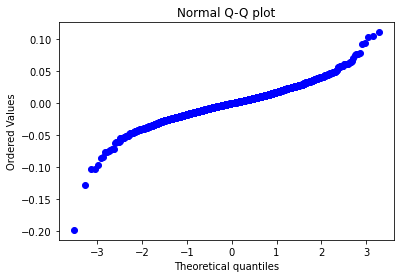

In [54]:
# Mostra o qq-plot da coluna Return
import matplotlib.pyplot as plt
import scipy.stats as stats

stats.probplot(final_data['Return'], dist="norm", plot=plt)
plt.title('Normal Q-Q plot')
plt.show()